<center><h1>Custom-NN</h1></center>
<center><h3>Implementing a neural network from scratch using Python</h3></center>
<center><h4><i>NumPy is all you need</i></h4></center>

<br/>

## Imports

In [1]:
from utils import (
    set_global_datatype,
    print_confusion_matrix
)

from mnist_dataset import (
    load_raw_MNIST_dataset_from_disk,
    plot_random_images_from_raw_MNIST_dataset,
    format_raw_MNIST_dataset
)

from network import Network

from layers import (
    InputLayer,
    DenseLayer,
    ActivationLayer,
    BatchNormLayer,
    DropoutLayer
)

from regularizers import L1, L2, L1_L2

from callbacks import EarlyStoppingCallback

<br/>

## Defining the datatype of <ins>all</ins> the data that will flow through the network

For now, the only accepted datatypes are `float32` (default) and `float64` :

In [2]:
# = "float32" (default) or "float64"
datatype = "float32"

set_global_datatype(datatype)

<br/>

## Variables that need to be manually defined (because they depend on the used dataset)

These variables are only related to the `Network.display_some_predictions` method, which is called at the very end of this notebook :

In [3]:
samples_are_images = True

if samples_are_images:
    # Format : (height, width), (height, width, 1) or (height, width, 3)
    #          (or `None` if the images are square-shaped, i.e. if their
    #          shape is either NxN, NxNx1 or NxNx3)
    default_image_shape = None

<br/>

## Optional variables

Here, `selected_classes` can either be :
- The string `"all"`, if you want to work with all the classes (default)
- A list/tuple/1D-array containing the specific class indices you want to work with (e.g. `[2, 4, 7]`). Note that, for the MNIST data, the class indices are <ins>equal</ins> to the digits themselves

In [4]:
selected_classes = "all"

If not set to `None`, `dict_of_real_class_names` is a dictionary with :
- As its keys   : **all** the selected class indices (as integers)
- As its values : the **real** names of the associated classes (as strings)

For instance, if you set `selected_classes` to `[2, 4, 7]`, then you could, if you want, set `dict_of_real_class_names` to the following dictionary :
`dict_of_real_class_names = {`<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`2 : "TWO",`<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`4 : "FOUR",`<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`7 : "SEVEN"`<br>
`}`

By default, if `dict_of_real_class_names` is set to `None`, then the class names will simply be the string representations of the selected class indices :

In [5]:
dict_of_real_class_names = None

<br/>

## Loading and formatting the data

### Seed

The following seed is currently used to :
- Randomly split the raw data into the "train/test" or "train/val/test" sets
- Randomly shuffle the "train/test" or "train/val/test" sets

Set this seed to `None` for "real" randomness during those 2 processes :

In [6]:
seed_data_formatting = 555

### Defining the number of samples in the "train/test" or "train/val/test" sets

**<ins>NB</ins>** : The validation set is extracted from the raw "train" data, not from the raw "test" data. As a reminder, for the MNIST dataset, there are :
- 60000 samples in the raw "train" data **(if all the classes are selected)**
- 10000 samples in the raw "test" data **(if all the classes are selected)**

In [7]:
nb_train_samples = 10000
nb_val_samples   = 1000 # can be set to zero if needed
nb_test_samples  = 1000

### Loading the raw data

In [8]:
raw_X_train, raw_y_train, raw_X_test, raw_y_test = load_raw_MNIST_dataset_from_disk(
    verbose=True
)


Shapes of the raw MNIST data :
    - X_train : (60000, 28, 28)
    - y_train : (60000,)
    - X_test  : (10000, 28, 28)
    - y_test  : (10000,)

Types of the raw MNIST data :
    - X_train : numpy.uint8
    - y_train : numpy.uint8
    - X_test  : numpy.uint8
    - y_test  : numpy.uint8

Ranges of the raw MNIST data :
    - X_train : 0 -> 255
    - y_train : 0 -> 9
    - X_test  : 0 -> 255
    - y_test  : 0 -> 9

Distribution of the class indices :

y_train :
    0 --> 09.87 %
    1 --> 11.24 %
    2 --> 09.93 %
    3 --> 10.22 %
    4 --> 09.74 %
    5 --> 09.04 %
    6 --> 09.86 %
    7 --> 10.44 %
    8 --> 09.75 %
    9 --> 09.91 %
y_test :
    0 --> 09.80 %
    1 --> 11.35 %
    2 --> 10.32 %
    3 --> 10.10 %
    4 --> 09.82 %
    5 --> 08.92 %
    6 --> 09.58 %
    7 --> 10.28 %
    8 --> 09.74 %
    9 --> 10.09 %

The raw MNIST dataset was successfully loaded from the disk. Done in 0.226 seconds


### Plotting random samples of each digit (from the raw data)

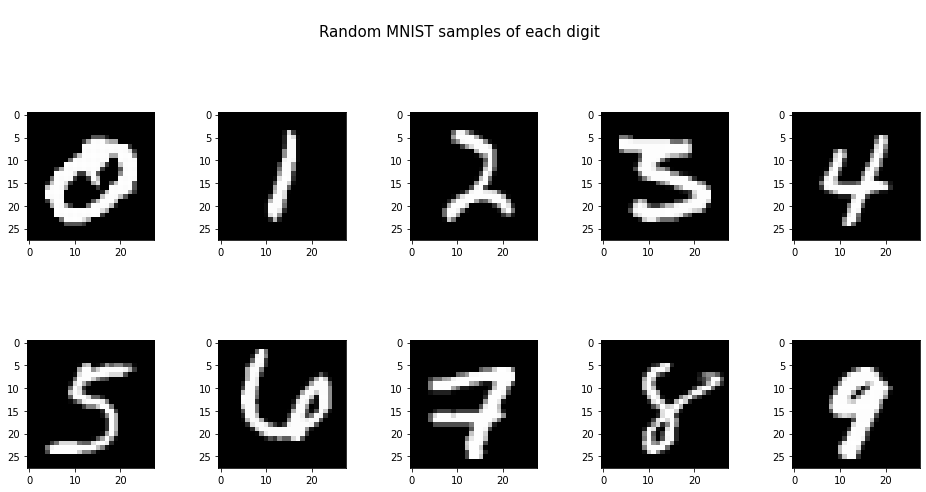

In [9]:
plot_random_images_from_raw_MNIST_dataset(
    raw_X_train,
    raw_y_train,
    raw_X_test,
    raw_y_test,
    seed=None
)

### Formatting the raw data

**<ins>NB</ins>** : If you set `nb_val_samples` to zero, `X_val` and `y_val` will both be equal to `None` :

In [10]:
X_train, y_train, X_val, y_val, X_test, y_test = format_raw_MNIST_dataset(
    raw_X_train,
    raw_y_train,
    raw_X_test,
    raw_y_test,
    nb_train_samples,
    nb_val_samples,
    nb_test_samples,
    selected_classes=selected_classes,
    dict_of_real_class_names=dict_of_real_class_names,
    nb_shuffles=20,
    seed=seed_data_formatting,
    verbose=True
)


Shapes of the formatted MNIST data :
    - X_train : (10000, 784)
    - y_train : (10000, 10)
    - X_val   : (1000, 784)
    - y_val   : (1000, 10)
    - X_test  : (1000, 784)
    - y_test  : (1000, 10)

Types of the formatted MNIST data :
    - X_train : numpy.float32
    - y_train : numpy.float32
    - X_val   : numpy.float32
    - y_val   : numpy.float32
    - X_test  : numpy.float32
    - y_test  : numpy.float32

Ranges of the formatted MNIST data :
    - X_train : 0.000 -> 1.000 (mean=0.130, std=0.307)
    - y_train : 0.000 -> 1.000 (one-hot encoded)
    - X_val   : 0.000 -> 1.000 (mean=0.130, std=0.307)
    - y_val   : 0.000 -> 1.000 (one-hot encoded)
    - X_test  : 0.000 -> 1.000 (mean=0.133, std=0.311)
    - y_test  : 0.000 -> 1.000 (one-hot encoded)

Distribution of the class indices :

y_train :
    0 --> 09.87 %
    1 --> 11.23 %
    2 --> 09.93 %
    3 --> 10.22 %
    4 --> 09.74 %
    5 --> 09.04 %
    6 --> 09.86 %
    7 --> 10.44 %
    8 --> 09.75 %
    9 --> 09.92 %


<br/>

## Checking the formatted data

**<ins>NB</ins>** : Assuming your data meets all the conditons described in the `README`, you don't need to change anything in this section

In [11]:
# Checking the validity of `X_train`, `y_train`, `X_test` and `y_test`,
# and returning their "corrected" counterparts

try:
    X_train, y_train, _ = Network._validate_data(X_train, y_train)
    X_test,  y_test,  _ = Network._validate_data(X_test,  y_test)
    
    assert X_train.shape[1] == X_test.shape[1], "X_train and X_test don't have the same number of features per sample !"
    assert y_train.shape[1] == y_test.shape[1], "y_train and y_test don't have the same number of classes !"
except (UnboundLocalError, NameError):
    raise Exception("Some training and/or testing data is not defined !")

In [12]:
# Checking the validity of `X_val` and `y_val` (if they exist, and are both
# not equal to `None`), and returning their "corrected" counterparts

try:
    if (X_val is not None) and (y_val is not None):
        X_val, y_val, _ = Network._validate_data(X_val, y_val)
        
        assert X_train.shape[1] == X_val.shape[1], "X_train and X_val don't have the same number of features per sample !"
        assert y_train.shape[1] == y_val.shape[1], "y_train and y_val don't have the same number of classes !"
    else:
        X_val, y_val = None, None
except (UnboundLocalError, NameError):
    # Here, it simply means that the validation data is not defined (which
    # isn't a problem, since it's optional)
    X_val, y_val = None, None

assert ("X_val" in locals()) and ("y_val" in locals())

_has_validation_data = ((X_val is not None) and (y_val is not None))

In [13]:
print("\nThe formatted data was successfully checked")


The formatted data was successfully checked


<br/>

## Defining the hyperparameters of the network's architecture

### Seed

The following seed is currently used to :<br>
- Randomly initialize the weights and biases of the Dense layers
- Randomly generate the dropout matrices of the Dropout layers (if these layers are used)
- Randomly split the training data into batches during the training phase (at each epoch)

Set this seed to `None` for "real" randomness during those 3 processes :

In [14]:
seed_network = 7777

### Input size of the network

In [15]:
# Input size = `nb_features_per_sample`
nb_features_per_sample = X_train.shape[1]

nb_features_per_sample

784

### Output size of the network

In [16]:
# Output size = `nb_classes` = number of (distinct) selected class indices
nb_classes = y_train.shape[1]

nb_classes

10

### Main hyperparameters

The following list defines the output sizes (or the "number of neurons") of each **Dense layer** of the network (in chronological order), **excluding the output Dense layer** :

In [17]:
nb_neurons_in_hidden_dense_layers = [
    256,
    64,
    32
]

Defining the name of the main activation function (case insensitive). Relevant choices here :
- `"ReLU"`
- `"leaky_ReLU"`
- `"PReLU"`
- `"tanh"`
- `"sigmoid"`

In [18]:
main_activation_name = "ReLU"

Defining the "leaky ReLU coefficient" (default value : `0.01`). It has to be a small positive constant in the range `]0, 1[`. If you didn't select the leaky ReLU activation as the main activation function, the defined `leaky_ReLU_coeff` kwarg will simply be discarded when processed by the main Activation layers :

In [19]:
main_activation_kwargs = {
    "leaky_ReLU_coeff" : 0.01
}

Defining the name of the output activation function (case insensitive). Relevant choices here :
- `"softmax"`
- `"log_softmax"` (you might have to increase the learning rate a bit to make it work)
- `"sigmoid"`&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; (you also might have to increase the learning rate a bit to make it work)

In [20]:
output_activation_name = "softmax"

### L1 and L2 regularizers

The higher the L1/L2 coefficients, the higher the constraints will be on the (maximum absolute values of the elements of the) weights and biases of the Dense layers. The L1 and L2 regularizations are used to help prevent overfitting (without necessarily improving the overall accuracy of the network) :

In [21]:
use_L1_L2_regularizers = False

if use_L1_L2_regularizers:
    """
    Usecases
    --------
    (L1_coeff != None) and (L2_coeff == None)  -->  L1(L1_coeff)
    (L1_coeff == None) and (L2_coeff != None)  -->  L2(L2_coeff)
    (L1_coeff != None) and (L2_coeff != None)  -->  L1_L2(L1_coeff, L2_coeff)
    """
    L1_coeff = None # has to lie in the range ]0, 1[ (if not `None`)
    L2_coeff = 0.01 # has to lie in the range ]0, 1[ (if not `None`)
    
    if (L1_coeff is not None) and (L2_coeff is None):
        regularizer = L1(L1_coeff)
    elif (L1_coeff is None) and (L2_coeff is not None):
        regularizer = L2(L2_coeff)
    elif (L1_coeff is not None) and (L2_coeff is not None):
        # Sidenote : If both `L1_coeff` and `L2_coeff` are equal, then,
        # equivalently, you can call `L1_L2(L1_coeff)` or `L1_L2(L2_coeff)`
        regularizer = L1_L2(L1_coeff, L2_coeff)
    else:
        raise ValueError("Please set a \"non-None\" value for `L1_coeff` and/or `L2_coeff`")
else:
    regularizer = None

### BatchNorm layers

The **BatchNorm layer** is a regularization layer that helps prevent overfitting (without necessarily improving the overall accuracy of the network). It basically standardizes (i.e. it normalizes with a mean of 0 and a standard deviation of 1) the outputs of the previous layer, and then applies an affine transform to the standardized outputs. The 2 parameters of the affine transform (typically called `gamma` and `beta`) are the trainable parameters of the layer :

In [22]:
use_batch_norm_layers = False

### Dropout layers

Just like the BatchNorm layer, the **Dropout layer** is a regularization layer that helps prevent overfitting, without necessarily improving the overall accuracy of the network. Basically, it randomly sets input values to 0 with a frequency of `dropout_rate` at each step during the training phase. This layer doesn't have any trainable parameters :

In [23]:
use_dropout_layers = False
dropout_rate = 0.30 # has to lie in the range ]0, 1[

<br/>

## Building the network's architecture from the previously defined hyperparameters

### Initializing the network

If you set the `standardize_input_data` kwarg to `True`, the training, testing and/or validation sets will be normalized such that their mean is 0 and their standard deviation is 1 (i.e. they will be standardized). It's highly recommended to set `normalize_input_data` to `True`, in order to get better results :

In [24]:
network = Network(standardize_input_data=True)

### Input layer

In [25]:
network.add(InputLayer(input_size=nb_features_per_sample))

### Hidden layers

In [26]:
seed = seed_network

# Creating the "main ActivationLayer template"
main_activation_layer = ActivationLayer(main_activation_name, **main_activation_kwargs)

# Creating the "BatchNormLayer template"
batch_norm_layer = BatchNormLayer()

for nb_neurons in nb_neurons_in_hidden_dense_layers:
    network.add(DenseLayer(
        nb_neurons,
        use_biases=True,
        regularizer=regularizer,
        seed=seed
    ))
    
    if use_batch_norm_layers:
        # Adding a BatchNorm regularization layer (if requested)
        network.add(batch_norm_layer)
    
    network.add(main_activation_layer)
    
    if use_dropout_layers:
        # Adding a Dropout regularization layer (if requested)
        network.add(DropoutLayer(dropout_rate, seed=seed))
    
    if seed is not None:
        # Updating the seed such that the "randomness" in the added
        # Dense/Dropout layers is different each time (in case 2
        # consecutive values of `nb_neurons` are the same)
        seed += 1 # The increment value is arbitrary

### Output layers

In [27]:
network.add(DenseLayer(
    nb_classes,
    use_biases=True,
    regularizer=regularizer,
    seed=seed
))

network.add(ActivationLayer(output_activation_name))

### Here would be the equivalent code to build the network, but using the `__call__` API instead :

In [28]:
use_call_API = False

if use_call_API:
    # Input Layer
    input_layer = InputLayer(input_size=nb_features_per_sample)
    x = input_layer # Renaming the input layer for convenience purposes
    
    # Creating the "main ActivationLayer template"
    main_activation_layer = ActivationLayer(main_activation_name, **main_activation_kwargs)
    
    # Creating the "BatchNormLayer template"
    batch_norm_layer = BatchNormLayer()
    
    # Hidden layers
    
    seed = seed_network
    
    for nb_neurons in nb_neurons_in_hidden_dense_layers:
        x = DenseLayer(
                nb_neurons,
                use_biases=True,
                regularizer=regularizer,
                seed=seed
        )(x)
        
        if use_batch_norm_layers:
            x = batch_norm_layer(x)
        
        x = main_activation_layer(x)
        
        if use_dropout_layers:
            x = DropoutLayer(dropout_rate, seed=seed)(x)
        
        if seed is not None:
            seed += 1 # The increment value is arbitrary
    
    # Output layers
    x = DenseLayer(
            nb_classes,
            use_biases=True,
            regularizer=regularizer,
            seed=seed
    )(x)
    x = ActivationLayer(output_activation_name)(x)
    output_layer = x # Renaming the output layer for convenience purposes
    
    # Building the network using the `__call__` API
    network = Network()(input_layer, output_layer)

### Displaying the summary of the network's architecture

**<ins>NB</ins>** : The kwargs of this method will only affect how the summary will look like when it's printed (they won't affect the summary's contents)

In [29]:
network.summary(
    column_separator="|",        # can be multiple characters long
    row_separator="-",           # has to be a single character
    bounding_box="*",            # has to be a single character
    alignment="left",            # = "left" (default), "right" or "center"
    transition_row_style="full", # = "full" (default) or "partial"
    column_spacing=2,
    horizontal_spacing=4,
    vertical_spacing=1,
    offset_spacing=1
)

# Or, equivalently, you can run `network.summary()` or `print(network)`


 ****************************************************************************************************************
 *                                                                                                              *
 *                                               NETWORK SUMMARY                                                *
 *                                                                                                              *
 *    |  Layer name    |  Layer type             |  Input shape  |  Output shape  |  Trainable parameters  |    *
 *    |----------------|-------------------------|---------------|----------------|------------------------|    *
 *    |  input_1       |  Input(784)             |  (None, 784)  |  (None, 784)   |  0                     |    *
 *    |  dense_1       |  Dense(256)             |  (None, 784)  |  (None, 256)   |  200,960               |    *
 *    |  activation_1  |  Activation("relu")     |  (None, 256)  |  (None, 256)   |  0 

<br/>

## Setting the hyperparameters related to the training phase

### Main hyperparameters

Number of times the trainable parameters will be updated using the **whole** training data :

In [30]:
nb_epochs = 50

If you lower the batch size, you might also want to lower the learning rate, in order to prevent the network from overfitting :

In [31]:
train_batch_size = 20

The learning rate is a small positive constant in the range `]0, 1[` :

In [32]:
learning_rate = 0.00001

### Optimizer

Defining the name of the weight optimization algorithm (case insensitive). Relevant choices here :
- `"SGD"` &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; (Stochastic Gradient Descent)
- `"Adam"` &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; (Adaptive Moment Estimation)
- `"RMSprop"` (Root Mean Square Propagation)

In [33]:
optimizer_name = "Adam"

# NB : For the "SGD" optimizer, the value of the learning rate usually
#      needs to be a bit higher than for the "Adam" and "RMSprop"
#      optimizers (in order to converge)

# Here, if you don't specify the `learning_rate` kwarg, the learning rate
# will be automatically set to 0.001
network.set_optimizer(
    optimizer_name,
    learning_rate=learning_rate,
    verbose=True
)


The network's optimizer was successfully set to "adam" (learning_rate=0.00001)


### Loss function

Defining the name of the loss function (case insensitive). Relevant choices here :
- `"CCE"` (Categorical Cross-Entropy)
- `"MSE"` (Mean Squared Error)

In [34]:
loss_function_name = "CCE"
network.set_loss_function(loss_function_name, verbose=True)


The network's loss function was successfully set to "cce"


### Validation kwargs

Here, inputting validation data is **<ins>optional</ins>**. If you don't want to use validation data, please (at least) set the `validation_data` kwarg to `None` (or don't specify it at all) :

In [35]:
if _has_validation_data:
    validation_kwargs = {
        "validation_data" : (X_val, y_val), # can be set to `None` if needed
        "val_batch_size"  : 32              # default value
    }
else:
    validation_kwargs = {}

### Callbacks (setting the `training_callbacks` kwarg)

So far, the only callback that has been implemented is the `EarlyStoppingCallback`. With the latter, you can monitor one of the following metrics :
- `"train_loss"`
- `"train_accuracy"`
- `"val_loss"`
- `"val_accuracy"`

Naturally, the two last metrics require that you input validation data to the `Network.fit` method :

In [36]:
if _has_validation_data:
    monitored_metric = "val_loss"
else:
    monitored_metric = "train_loss"

The early stopping callback will check if the sequence formed by the  last `patience` monitored values (of the last `patience` epochs) is strictly monotonous (in the "wrong direction"). If that's the case, then the training loop is prematurely stopped. Basically :
- If a loss is being monitored : since the losses are meant to be minimized, it'll check if the monitored loss has only been increasing over the past `patience` epochs
- If an accuracy is being monitored : since the accuracies are meant to be maximized, it'll check if the monitored accuracy has only been decreasing over the past `patience` epochs

In [37]:
early_stopping_callback = EarlyStoppingCallback(
    monitor=monitored_metric,
    patience=5 # has to be >= 2
)

# You can set `training_callbacks` to `None` (or to the empty list/tuple)
# if needed
training_callbacks = [early_stopping_callback]

<br/>

## Training phase

**<ins>NB</ins>** : If you set the `enable_checks` kwarg to `False` (to *slightly* speed up the training), please first make sure your network runs a couple of epochs without raising any exceptions when the same kwarg is set to `True` !

In [38]:
network.fit(
    X_train,
    y_train,
    nb_epochs,
    train_batch_size,
    nb_shuffles_before_each_train_batch_split=10,
    seed_train_batch_splits=seed_network,
    **validation_kwargs,
    training_callbacks=training_callbacks,
    enable_checks=True
)


# --------------------------------------------------------------------------------------- #

     Starting the training loop ...

     epoch 01/50 :
     train_loss=2.6706 - val_loss=2.0741 - train_accuracy=0.2321 - val_accuracy=0.3340                                                                

     epoch 02/50 :
     train_loss=1.8014 - val_loss=1.6210 - train_accuracy=0.4340 - val_accuracy=0.5090                                                                

     epoch 03/50 :
     train_loss=1.4072 - val_loss=1.2641 - train_accuracy=0.5928 - val_accuracy=0.6320                                                                

     epoch 04/50 :
     train_loss=1.0201 - val_loss=0.9303 - train_accuracy=0.7106 - val_accuracy=0.7290                                                                

     epoch 05/50 :
     train_loss=0.7531 - val_loss=0.7558 - train_accuracy=0.7939 - val_accuracy=0.7820                                                                

     epoch 06/

Saving the network to the disk (if requested). By default, if the network is saved, it will be saved in the `saved_networks` folder as a Gunzip file (i.e. as a ".gz" file) :

In [39]:
save_network_to_disk = False

if save_network_to_disk:
    network_filename = "network"
    network.save(network_filename)
    
    # Here, the saved network is reloaded and tested just for debugging purposes
    
    loaded_network = Network.load_network_from_disk(network_filename)
    test_accuracy_of_loaded_network = loaded_network.evaluate(X_test, y_test)[0]
    
    precision_accuracy = 2 # by default
    print(f"\nTesting accuracy of the loaded network : {test_accuracy_of_loaded_network:.{precision_accuracy}f} %\n")

<br/>

## RESULTS

### Plotting the network's history

By default, if the plot is saved, it will be saved in the `saved_plots` folder as a **PNG image** :

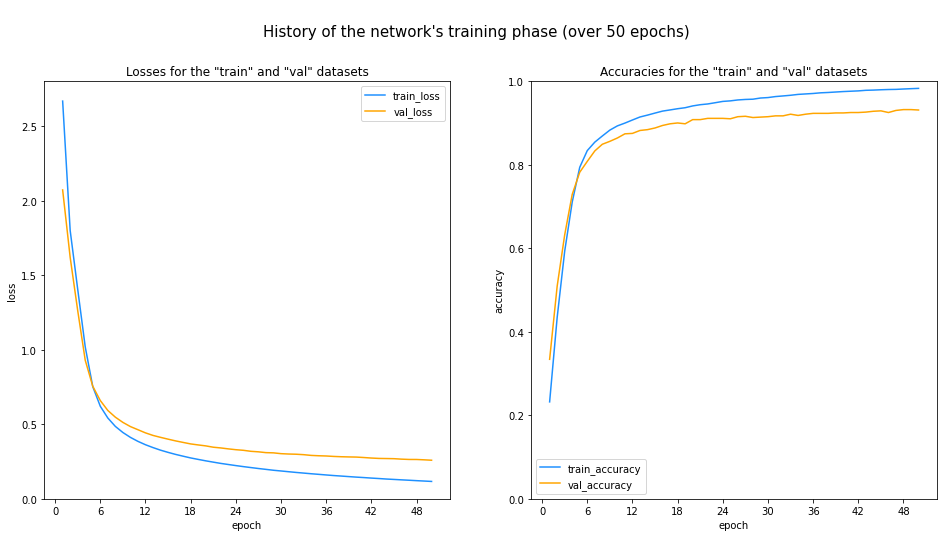

In [40]:
network.plot_history(
    save_plot_to_disk=False,
    saved_image_name="network_history"
)

### Computing the global accuracy scores, the testing loss, the mean confidence levels and the raw confusion matrix of the network

The "top-N accuracy" is defined as the proportion of the true classes that lie within the `N` most probable predicted classes (here, `N` is actually `top_N_accuracy`) :

In [41]:
top_N_accuracy = 2

testing_results = network.evaluate(
    X_test,
    y_test,
    top_N_accuracy=top_N_accuracy,
    test_batch_size=32 # default value
)

assert len(testing_results) == 6

acc_score, top_N_acc_score, test_loss = testing_results[ : 3]

mean_confidence_level_correct_predictions = testing_results[3]
mean_confidence_level_false_predictions   = testing_results[4]

conf_matrix = testing_results[5]

### Displaying the (raw and normalized) <ins>confusion matrices</ins> of the network

**<ins>NB</ins>** : When you load this notebook for the first time, the confusion matrices won't be highlighted in the specified color (the outputs will be the unstyled confusion matrices). Simply re-run the entire notebook to see their highlighting !

In [42]:
for normalize in ["no", "columns", "rows"]:
    print_confusion_matrix(
        conf_matrix,
        selected_classes=selected_classes,
        dict_of_real_class_names=dict_of_real_class_names,
        normalize=normalize, # = "columns" (default), "rows" or "no"
        precision=1,
        color="green" # = "green" (default), "blue", "purple", "red" or "orange"
    )


RAW CONFUSION MATRIX (normalized="no") :


PREDICTED,0,1,2,3,4,5,6,7,8,9
ACTUAL,,,,,,,,,,
0,95,0,0,1,0,0,1,0,1,0
1,0,112,1,0,0,0,0,0,0,1
2,0,0,97,1,0,1,0,2,1,1
3,0,0,0,97,0,0,0,1,1,2
4,0,0,0,0,95,0,2,0,0,1
5,2,0,1,2,0,82,1,0,1,0
6,4,0,0,0,1,2,88,0,1,0
7,1,1,0,1,0,0,0,98,1,1
8,1,0,1,1,2,1,1,1,87,2



NETWORK PRECISION - NORMALIZED CONFUSION MATRIX (normalized="columns") :


PREDICTED,0,1,2,3,4,5,6,7,8,9
ACTUAL,,,,,,,,,,
0,91.3 %,0.0 %,0.0 %,1.0 %,0.0 %,0.0 %,1.1 %,0.0 %,1.1 %,0.0 %
1,0.0 %,99.1 %,1.0 %,0.0 %,0.0 %,0.0 %,0.0 %,0.0 %,0.0 %,1.0 %
2,0.0 %,0.0 %,97.0 %,1.0 %,0.0 %,1.1 %,0.0 %,1.9 %,1.1 %,1.0 %
3,0.0 %,0.0 %,0.0 %,94.2 %,0.0 %,0.0 %,0.0 %,1.0 %,1.1 %,2.0 %
4,0.0 %,0.0 %,0.0 %,0.0 %,96.0 %,0.0 %,2.2 %,0.0 %,0.0 %,1.0 %
5,1.9 %,0.0 %,1.0 %,1.9 %,0.0 %,93.2 %,1.1 %,0.0 %,1.1 %,0.0 %
6,3.8 %,0.0 %,0.0 %,0.0 %,1.0 %,2.3 %,94.6 %,0.0 %,1.1 %,0.0 %
7,1.0 %,0.9 %,0.0 %,1.0 %,0.0 %,0.0 %,0.0 %,94.2 %,1.1 %,1.0 %
8,1.0 %,0.0 %,1.0 %,1.0 %,2.0 %,1.1 %,1.1 %,1.0 %,92.6 %,2.0 %



NETWORK RECALL - NORMALIZED CONFUSION MATRIX (normalized="rows") :


PREDICTED,0,1,2,3,4,5,6,7,8,9
ACTUAL,,,,,,,,,,
0,96.9 %,0.0 %,0.0 %,1.0 %,0.0 %,0.0 %,1.0 %,0.0 %,1.0 %,0.0 %
1,0.0 %,98.2 %,0.9 %,0.0 %,0.0 %,0.0 %,0.0 %,0.0 %,0.0 %,0.9 %
2,0.0 %,0.0 %,94.2 %,1.0 %,0.0 %,1.0 %,0.0 %,1.9 %,1.0 %,1.0 %
3,0.0 %,0.0 %,0.0 %,96.0 %,0.0 %,0.0 %,0.0 %,1.0 %,1.0 %,2.0 %
4,0.0 %,0.0 %,0.0 %,0.0 %,96.9 %,0.0 %,2.0 %,0.0 %,0.0 %,1.0 %
5,2.2 %,0.0 %,1.1 %,2.2 %,0.0 %,92.1 %,1.1 %,0.0 %,1.1 %,0.0 %
6,4.2 %,0.0 %,0.0 %,0.0 %,1.0 %,2.1 %,91.7 %,0.0 %,1.0 %,0.0 %
7,1.0 %,1.0 %,0.0 %,1.0 %,0.0 %,0.0 %,0.0 %,95.1 %,1.0 %,1.0 %
8,1.0 %,0.0 %,1.0 %,1.0 %,2.1 %,1.0 %,1.0 %,1.0 %,89.7 %,2.1 %


### Displaying the <ins>testing loss</ins>, the <ins>global accuracy scores</ins> and the <ins>mean confidence levels</ins> of the network

In [43]:
precision_loss = 4 # by default
print(f"\nTESTING LOSS    : {test_loss:.{precision_loss}f}")

precision_accuracy = 2 # by default
print(f"\nGLOBAL ACCURACY : {acc_score:.{precision_accuracy}f} %")
potential_extra_space = " " * int(top_N_accuracy < 10)
print(f"TOP-{top_N_accuracy}{potential_extra_space} ACCURACY : {top_N_acc_score:.{precision_accuracy}f} %")

mean_confidence_level_precision = 2 # by default
print(f"\nMEAN CONFIDENCE LEVEL (FOR CORRECT PREDICTIONS) : {mean_confidence_level_correct_predictions:.{mean_confidence_level_precision}f} %")
print(f"MEAN CONFIDENCE LEVEL (FOR FALSE PREDICTIONS)   : {mean_confidence_level_false_predictions:.{mean_confidence_level_precision}f} %\n")



TESTING LOSS    : 0.2034

GLOBAL ACCURACY : 94.50 %
TOP-2  ACCURACY : 97.80 %

MEAN CONFIDENCE LEVEL (FOR CORRECT PREDICTIONS) : 94.70 %
MEAN CONFIDENCE LEVEL (FOR FALSE PREDICTIONS)   : 61.87 %



### Displaying some of the network's predictions (assuming the rows of `X_test` are flattened <ins>images</ins>)

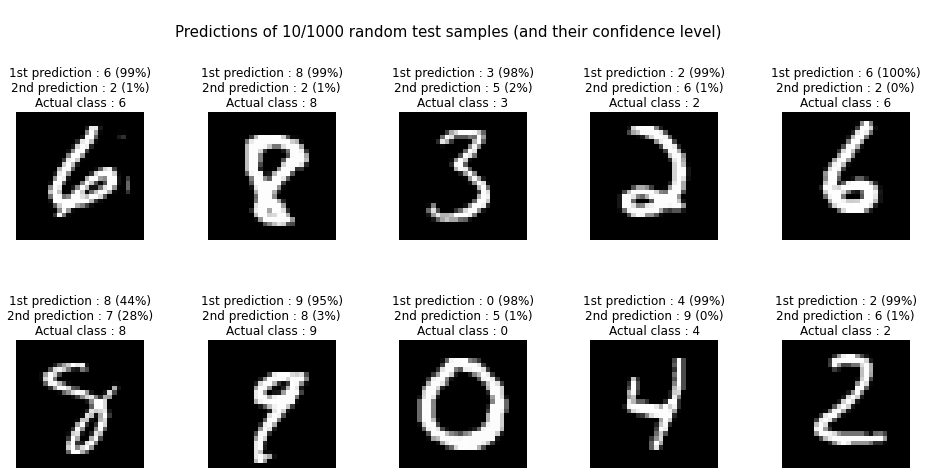

In [44]:
if samples_are_images:
    network.display_some_predictions(
        X_test,
        y_test,
        selected_classes=selected_classes,
        dict_of_real_class_names=dict_of_real_class_names,
        image_shape=default_image_shape,
        seed=None
    )

<br/>

<center><h2>END</h2></center>